<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-Вывод" data-toc-modified-id="Общий-Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Импорт библиотек:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler)
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

import time

RANDOM_STATE = 42

## Подготовка

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Тип индекса:

In [4]:
print(type(data.index))
data.sort_index(inplace=True)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Произведем ресеплирование по часу:

In [5]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Оценим монотонность данных: True = монотонны

In [6]:
print(f'Монотонность индекса: {data.index.is_monotonic}')

Монотонность индекса: True


Добавим столбец скользящее среднее и стандартное отклонение, построим график. Видно, что процесс зависит от времени - он нестационарный, среднее и стд.откл. меняется.

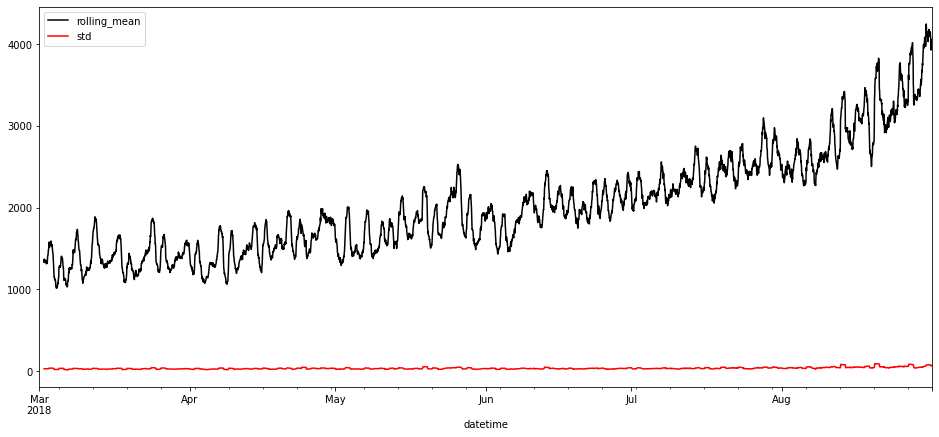

In [7]:
data['rolling_mean'] = data.rolling(24).sum()
data['std'] = data['num_orders'].shift().rolling(24).std()
data.drop(columns='num_orders', axis=1).plot(figsize=(16,7), color = ['black', 'red', 'green']);

Посмотрим на отсортированные данные, видно, что наибольшее количество заказав в близкие по времени промежутки: 2018-08-20 02:00:00, 2018-08-13 02:00:00, 2018-08-27 02:00:00 и так далее в августе. Возможно это связано с сезонностью, все возвращаются из отпуска. Проверим на тренды сезонности далее.

In [8]:
data.sort_values(by='num_orders', ascending=False).head(20)

,num_orders,rolling_mean,std
datetime,,,
2018-08-20 02:00:00,462,3329.0,55.182290
2018-08-13 02:00:00,437,3068.0,52.190010
2018-08-27 02:00:00,408,3623.0,61.179218
2018-08-30 17:00:00,342,4189.0,64.613847
2018-08-27 04:00:00,295,3745.0,79.292524
2018-08-18 00:00:00,281,3312.0,44.989532
2018-08-26 00:00:00,281,3456.0,55.715634
2018-08-31 00:00:00,276,4150.0,75.422241
2018-08-13 01:00:00,273,2788.0,42.409665


In [9]:
data.isna().sum()

num_orders       0
rolling_mean    23
std             24
dtype: int64

Seasonal_decompose не работает с пропущенными значениями - удалим колонки со скользящим средним и со стандартным отклонением в новом датафрейме.

In [10]:
data_dec = data['num_orders']
decomposed = seasonal_decompose(data_dec) 

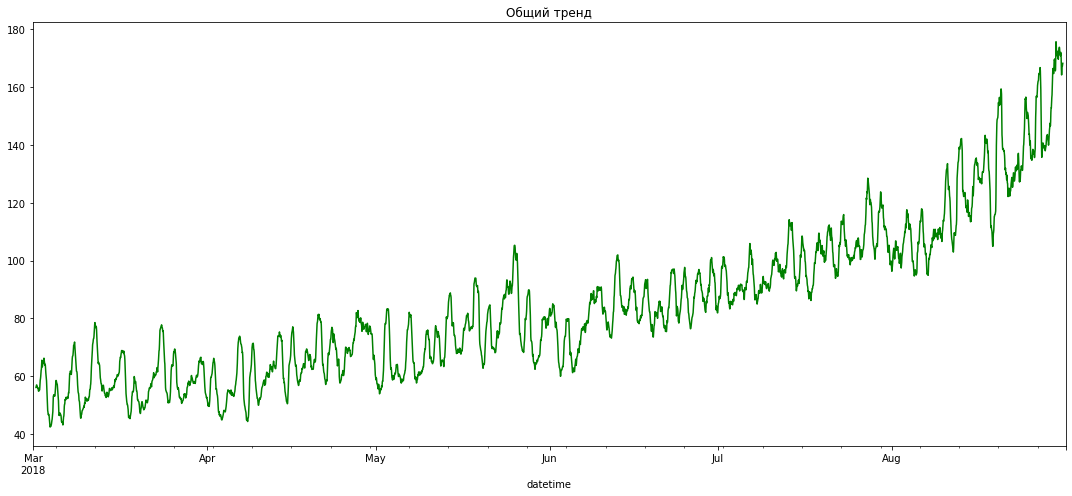

In [11]:
decomposed.trend.plot(ax=plt.gca(), color='green', figsize=(15,7)) 
plt.title('Общий тренд')
plt.tight_layout()
plt.show()

**По общему тренду** можно наблюдать повышение количества заказов с марта 2018 до августа 2018.

In [12]:
data_2 = data.resample('1D').sum()
data_2.head()

,num_orders,rolling_mean,std
datetime,,,
2018-03-01,1364,1364.0,0.000000
2018-03-02,1506,32951.0,718.024443
2018-03-03,1290,36121.0,879.385120
2018-03-04,1141,26064.0,502.503699
2018-03-05,1259,31585.0,805.812039


In [13]:
data_dec_2 = data_2['num_orders']
decomposed = seasonal_decompose(data_dec_2) 

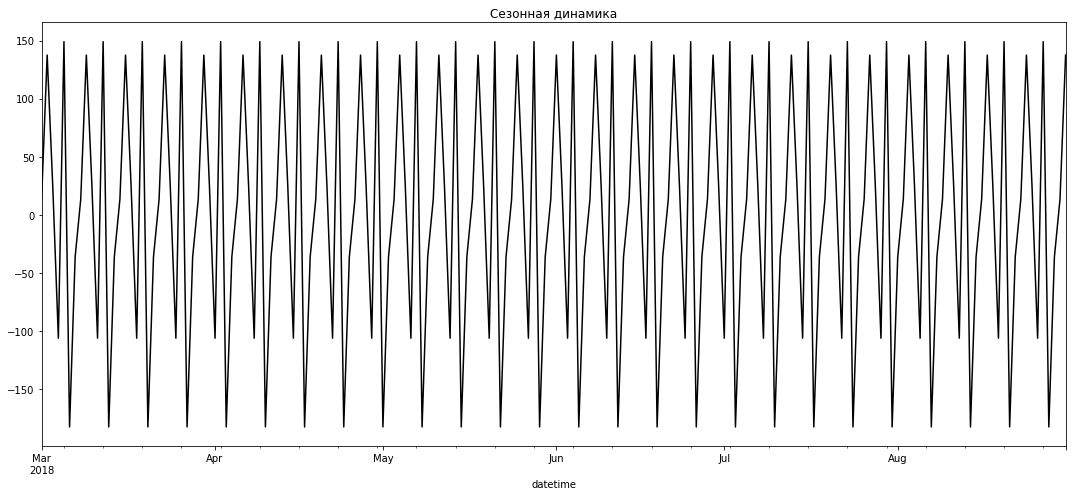

In [14]:
decomposed.seasonal.plot(ax=plt.gca(), color='black', figsize=(15,7)) 
plt.title('Сезонная динамика')
plt.tight_layout()
plt.show()

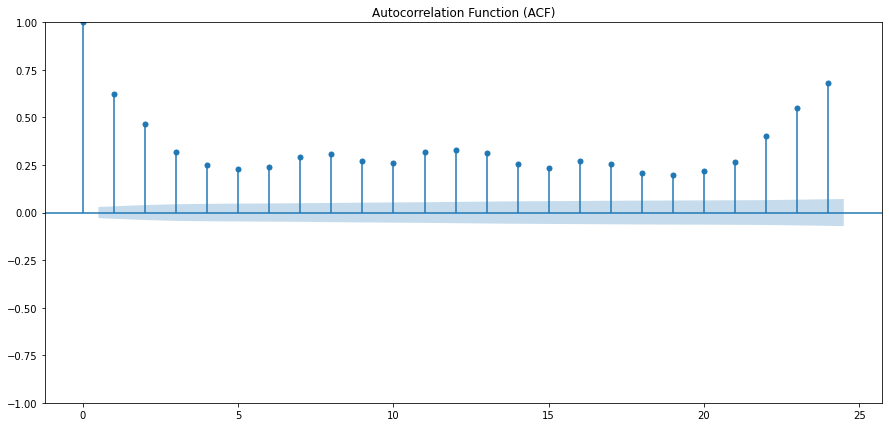

In [15]:
plt.figure(figsize=(15,7))
plot_acf(data['num_orders'], lags=24, ax=plt.gca())  
plt.title('Autocorrelation Function (ACF)')
plt.show()

Наиболее выражена суточная корреляция (суточная сезонность) во временном ряду, что может указывать на использование лага 24 и рамки скользящего среднего 24

**Выводы:**

1. Данные монотонны
2. Ряд нестационарный
3. Наибольшее количество заказов в августе
4. По общему тренду можно наблюдать повышение количества заказов с марта 2018 до августа 2018

## Обучение

Создадим признаки для обучения модели, скорее всего в заказах имеет значение день недели, день и месяц. Также создадим лаг, по моему мнению лаг должен соответсвтвать длительности часа пик - 3 часа.

Произведем разбивку на тестовые и тренировочные данные, проверим, чтобы тестовая выборка была строго после тренировочной по временному ряду.

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(lag).rolling(rolling_mean_size).mean()

    
make_features(data, 24, 24)    

Разбивка данных и удаление пропусков в лагах и скользящем среднем:

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

print('Тренировочная выборка, минимум и максимум:', train.index.min(),'-', train.index.max())
print('Тестовая выборка, минимум и максимум:', test.index.min(),'-', test.index.max())

train = train.dropna()

Тренировочная выборка, минимум и максимум: 2018-03-01 00:00:00 - 2018-08-13 13:00:00
Тестовая выборка, минимум и максимум: 2018-08-13 14:00:00 - 2018-08-31 23:00:00


In [18]:
X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

num_columns = ['rolling_mean', 'std', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24']

Построим пайплайн с моделями без датапроцессинга(т.к. все данные числовые примерно на одной шкале, шкалирование не имеет смысла)

In [19]:
data_preprocessor = ColumnTransformer(
    [
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough')

In [20]:
pipe_final = Pipeline([
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(4, 7),
        'models__max_features': range(5, 7),  
    },
    {
        'models': [LinearRegression()],
    },
    {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves': [10, 20],
        'models__learning_rate': [0.01, 0.1],
    }
]

In [21]:
start_time = time.time()
tscv = TimeSeriesSplit(n_splits=3)
random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    n_iter=11, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)


random_search.fit(X_train, y_train)

end_time = time.time()

print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели:', abs(random_search.best_score_))
print(f'Время потраченное на подбор модели и обучение: {end_time - start_time:.4f} секунд')

Лучшая модель и её параметры:

 Pipeline(steps=[('models', LGBMRegressor(num_leaves=10, random_state=42))])
Метрика лучшей модели: 27.77637434225507
Время потраченное на подбор модели и обучение: 1921.4936 секунд


Построим датасет с данными модели по результатам кросс-валидации:

In [22]:
result = pd.DataFrame(random_search.cv_results_)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

result['mean_test_score'] = abs(result['mean_test_score'])

result['model'] = result['params'].apply(lambda x: x['models'].__class__.__name__)

In [23]:
best_indices = result.groupby('model')['mean_test_score'].idxmin()
best_models = result.iloc[best_indices]
display(best_models[['model','params', 'mean_test_score', 'mean_fit_time', 'mean_score_time']])

,model,params,mean_test_score,mean_fit_time,mean_score_time
3,DecisionTreeRegressor,"{'models__max_features': 6, 'models__max_depth': 5, 'models': DecisionTreeRegressor(random_state=42)}",33.635390,0.006492,0.001983
9,LGBMRegressor,"{'models__num_leaves': 10, 'models__learning_rate': 0.1, 'models': LGBMRegressor(random_state=42)}",27.776374,14.364358,0.104910
6,LinearRegression,{'models': LinearRegression()},28.390965,0.034750,0.008250


На схеме показаны самые лучшие гиперпараметры каждого модельного ядра. Самой лучшей по метрике, но не самой лучшей по скорости является **LGBMRegressor	{'models__num_leaves': 10, 'models__learning_rate': 0.1, 'models': LGBMRegressor(num_leaves=10, random_state=42)}**	

## Тестирование

Проведем тестирование на тестовом датафрейме, предскажем по обученной модели:

In [24]:

start_time = time.time()
y_pred = random_search.predict(X_test)
end_time = time.time()
print(f'Метрика RMSE на тестовой выборке: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
print(f'Время потраченное на применение модели: {end_time - start_time:.4f} секунд')

Метрика RMSE на тестовой выборке: 42.57
Время потраченное на применение модели: 0.1051 секунд


**Вывод: результаты тестирования удволетворяют условию. RMSE меньше 48, модель работает удволетворительно.**

## Общий Вывод

В ходе работы был исследован временной ряд для данных заказа такси в аэропортах, были выполнены следующие работы:
1. Загрузка и анализ данных, в ходе которых было выявлено, что в данных присутствует суточная и недельная периодичность.
2. Была выполенна подготовка данных, на основе суточной периодичносты были рассчитаны 24 лага, также рассчитано скользящее среднее также с окном в 24 часа.
3. Модели были обучены и протестированы на тестовом наборе данных, выбрана модель с ядром LGBM и гиперпараметрами {'models__num_leaves': 10, 'models__learning_rate': 0.1}, для выявления корректности работы модели использована метрика RMSE, метрика находилась для тренировоченой и тестовой выборки в пределах допуска (менее 48).